In [1]:
from __future__ import division
from collections import OrderedDict  # Preserves order of insertion
import time
import numpy as np
import scipy.signal as sig

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

from keras.callbacks import EarlyStopping

from shootout import stride_wit, get_signals, make_NN

Using Theano backend.


In [2]:
# Data generation parameters
fs = 1
sec = 2**20/fs  # ~1 Million samples

fpole = 2**-5  # 32 samples per cycle
q = 8
order = 4

# NN parameters
layers = [2]
chunkcycles = [q//2, q, 2*q, 4*q]
chunksizes = [int(c/fpole) for c in chunkcycles]

# Training parameters
nb_epoch = 30     # How many times to iterate over training data set at maximum
batch_size = 128  # How many data points to use per gradient update
val_split = 0.2   # Fraction of data to save for validation

fit_opts = {'batch_size': batch_size,
            'nb_epoch': nb_epoch,
            'verbose': False,
            'validation_split': val_split,
            # Stop fitting if validation hasn't improved in some number of epochs
            'callbacks': [EarlyStopping(patience=3)],
            }

In [3]:
wit, tar, sys = get_signals(order, sec=sec, fs=fs, fpole=fpole, q=q)

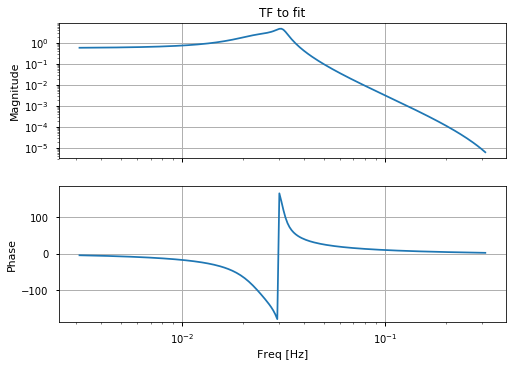

In [4]:
fresp = np.logspace(np.log10(fpole)-1, np.log10(min(.9*fs/2, 10*fpole)), 200)
w, hh = sys.freqresp(w=np.pi*fresp/(fs/2))
fb, ab = plt.subplots(nrows=2, sharex=True)
ab[0].loglog(fresp, np.abs(hh))
ab[1].semilogx(fresp, np.angle(hh, deg=True))
ab[1].set_ylim([-185, 185])
ab[0].grid(True)
ab[1].grid(True)
ab[0].set_title('TF to fit')
ab[0].set_ylabel('Magnitude')
ab[1].set_ylabel('Phase')
ab[1].set_xlabel('Freq [Hz]')

In [5]:
# Train different models
def trainjob(nlayer, Nchunk):
    train = stride_wit(wit, Nchunk)
    model = make_NN(train.shape[-1], nlayer=nlayer, activation='relu')
    fit = model.fit(train, tar[-train.shape[0]:], **fit_opts)
    return fit

fits = OrderedDict()
for nL in layers:
    for nC in chunksizes:
        start = time.time()
        fit = trainjob(nL, nC)
        end = time.time()
        fits[(nL, nC)] = fit
        print('Trained {} layers, {} samples in {:.3g} '
              'sec ({} epochs)'.format(nL, nC, end-start,len(fit.history['val_loss'])))

Trained 2 layers, 128 samples in 139 sec (29 epochs)
Trained 2 layers, 256 samples in 148 sec (30 epochs)
Trained 2 layers, 512 samples in 25.1 sec (5 epochs)
Trained 2 layers, 1024 samples in 114 sec (15 epochs)


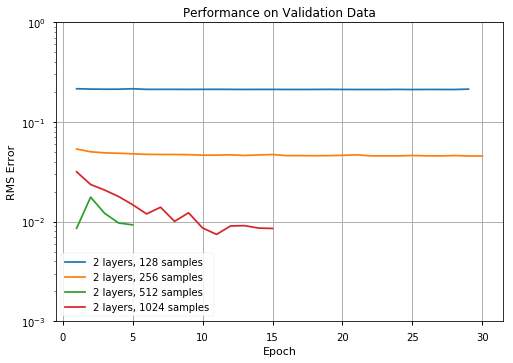

In [6]:
# Plot loss over training time
plt.figure()
for (nL, nC), fit in fits.iteritems():
    plt.plot(np.arange(len(fit.history['val_loss']))+1, np.sqrt(fit.history['val_loss']),
             label='{} layers, {} samples'.format(nL, nC))

plt.title('Performance on Validation Data')
plt.ylabel('RMS Error')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend()
plt.ylim([1e-3, 1])
plt.grid(True)

In [7]:
# Evaluate on validation data
nval = int(np.round(wit.size*val_split))
nperseg = chunksizes[-1]
psubs = OrderedDict()
ff, ptar = sig.welch(tar[-nval:], fs=fs, nperseg=nperseg)

for (nL, nC), fit in fits.iteritems():
    val = stride_wit(wit[-(nval+int(nC)-1):], nC)
    pred = fit.model.predict(val)[:,0]
    res = tar[-nval:] - pred
    
    _, psub = sig.welch(res, fs=fs, nperseg=nperseg)
    
    psubs[(nL, nC)] = psub

In [8]:
# Compare with FIR Wiener filter
import noisesub as n
W = n.wiener_fir(tar[:nval], wit[:nval], 512)
pred = sig.lfilter(W[0], 1, wit)
res = tar[-nval:] - pred[-nval:]
_, pwf = sig.welch(res, fs=fs, nperseg=nperseg)

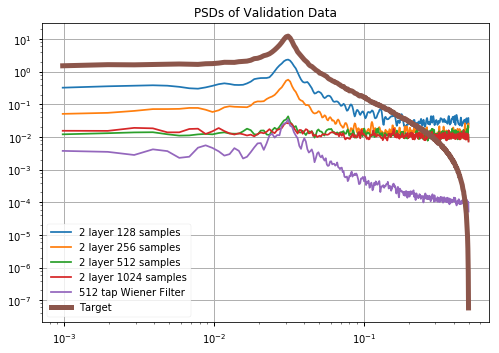

In [9]:
plt.figure()
for (nL, nC), psub in psubs.iteritems():
    plt.loglog(ff, np.sqrt(psub),
               label='{} layer {} samples'.format(nL, nC))
plt.loglog(ff, np.sqrt(pwf), label='512 tap Wiener Filter')
plt.loglog(ff, np.sqrt(ptar), label='Target', lw=5)
plt.title('PSDs of Validation Data')
plt.grid(True)
plt.legend()